In [2]:
import pandas as pd
import numpy as np
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import os
import scipy.io

## Model

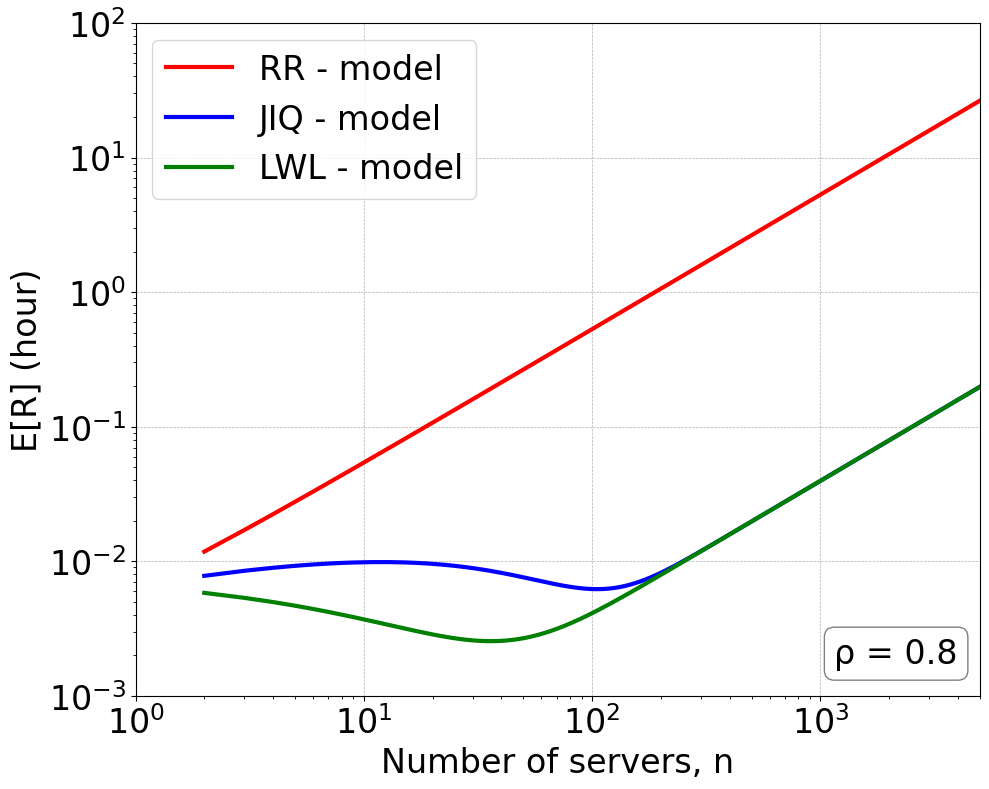

In [3]:

# Load data from .mat file
df = pd.read_csv('Alibaba_daily.csv')
df = df.sort_values(by='CPU')
rows_to_drop = int(len(df) * 0.001)  # 0.1% of the total rows
df = df.iloc[:-rows_to_drop]
df = df.sort_values(by='Arrival_Time')

AJv = df['Arrival_Time'].values
CJv = df['CPU'].values

AJallv = AJv
CJallv = CJv
njob = len(AJv)
xv = np.sort(CJallv)
cutquant = 1
th = xv[int(np.ceil(cutquant * len(xv))) - 1]
jv = CJallv <= th
AJrv = AJallv[jv]
CJrv = CJallv[jv]
njobr = len(jv)

# Arrival process moments
Timehorizon = AJrv[-1] - AJrv[0]
IATv = np.diff(AJrv)
lambda_ = 1 / np.mean(IATv)
CA = np.std(IATv) / np.mean(IATv)
EC = np.mean(CJrv)
CX = np.std(CJrv) / EC

# Mean response time analysis
rho0 = 0.8
mutot = np.sum(CJrv) / Timehorizon / rho0

Nmin, Nmax = 2, 5000
Nv = np.arange(Nmin, Nmax + 1)
numN = len(Nv)

ERsinglestageRRv = []
ERsinglestageLWLv = []
ERsinglestageJIQv = []

for N in Nv:
    mu = mutot / N
    lambda1 = lambda_ / N
    CA1 = CA / np.sqrt(N)
    EX1 = EC / mu
    CX1 = CX
    rho1 = lambda1 * EX1
    scalef1 = (1 + CX1**2) * (CA1**2 + (rho1 * CX1)**2) / (1 + (rho1 * CX1)**2) / 2
    ERsinglestageRR = EX1 + EX1 * (rho1 / (1 - rho1)) * scalef1
    ERsinglestageRRv.append(ERsinglestageRR)

    EX = EC / mu
    A = N * rho1
    B = 1
    for hhh in range(1, N + 1):
        B = A * B / (hhh + A * B)
    C = B / (1 - rho0 + rho0 * B)
    scalef = (1 + CX**2) * (CA**2 + (rho0 * CX)**2) / (1 + (rho0 * CX)**2) / 2
    ERsinglestageLWL = EX + EX * (C / (N * (1 - rho0))) * scalef
    ERsinglestageLWLv.append(ERsinglestageLWL)

   

    # --- JIQ mixture uses Pb instead of plain B ---
    ERsinglestageJIQ = (1 - B) * ERsinglestageLWL + B * ERsinglestageRR
    ERsinglestageJIQv.append(ERsinglestageJIQ)


# Plot results
sechour = 3600
y1v = np.array(ERsinglestageRRv) / sechour
y2v = np.array(ERsinglestageJIQv) / sechour
y3v = np.array(ERsinglestageLWLv) / sechour

plt.figure(figsize=(10, 8))
plt.loglog(Nv, y1v, 'r-', linewidth=3.0, label="RR - model")
plt.loglog(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - model")
plt.loglog(Nv, y3v, 'g-', linewidth=3.0, label="LWL - model")

plt.xlabel('Number of servers, n', fontsize=24)
plt.ylabel('E[R] (hour)', fontsize=24)
plt.legend(loc="upper left", fontsize=24)

plt.grid(True, which="major", linestyle='--', linewidth=0.5)
plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(y3v))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

plt.text(
    0.80 * max(Nv), 0.25 * min(y2v),  # Adjust x and y coordinates
    f"ρ = {rho0}",
    fontsize=24,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)
plt.tight_layout()
plt.show()


## Simulations

In [4]:
def RR_FCFS_calc_ER(Nse):
    rho = 0.8
    ntask = len(Av)
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    XJv = CJv / mu
    Jv = jobIDppv

    # Initialization
    tnow = 0
    Uv = np.zeros(Nse)
    Sv = np.zeros(ntask, dtype=int)
    Dv = np.zeros(ntask)
    Rv = np.zeros(ntask)
    SDv = np.zeros(ntask)
    joblistv = np.unique(Jv)
    njob = len(joblistv)
    Rjobv = np.zeros(njob)
    Xjobv = np.zeros(njob)
    SDjobv = np.zeros(njob)
    tstartjobv = np.inf * np.ones(njob)
    tendjobv = np.zeros(njob)
    Xmaxjobv = np.zeros(njob)
    workv = np.zeros(Nse)
    calc_prob = []

    # List to store mean and standard deviation of workloads
    workload_stats = []

    for ii in range(ntask):

        A = Av[ii]
        X = Xv[ii]
        elapsedtime = A - tnow
        tnow = A
        Uv = np.maximum(0, Uv - elapsedtime)

        if 0 in Uv:
            calc_prob.append(1)
        else:
            calc_prob.append(0)

        # Round Robin dispatching
        jsel = ((ii - 1) % Nse)
        Sv[ii] = jsel
        Uv[jsel] += X
        workv[jsel] += X

        # Response time and SD of task
        R = Uv[jsel]
        Dv[ii] = A + R
        Rv[ii] = R
        SDv[ii] = R / X

        # Start and end times of job
        jobindx = np.where(joblistv == Jv[ii])[0][0]  # Adjusted to handle non-integer job indexes
        Xmaxjobv[jobindx] = max(Xmaxjobv[jobindx], X)
        tstartjobv[jobindx] = min(tstartjobv[jobindx], A)
        tendjobv[jobindx] = max(tendjobv[jobindx], A + R)

        # Compute the mean and standard deviation of server workloads (Uv) at each task arrival
        workload_mean = np.mean(Uv)
        workload_std = np.std(Uv)

        # Store the mean and std in the workload_stats list
        workload_stats.append((workload_mean, workload_std))

    ER = np.mean(Rv)
    ESD = np.mean(SDv)

    # Mean job response time and slowdown for jobs
    Rjobv = tendjobv - tstartjobv
    ERjob = np.mean(Rjobv)
    SDjobv = Rjobv / Xmaxjobv  # Slowdown for jobs
    ESlowdownjob = np.mean(SDjobv)  # Average slowdown for jobs

    # Return the metrics and workload statistics
    return (ER, ERjob, ESlowdownjob, workload_stats)

In [5]:
def JIQ_FCFS_calc_ER(Nse):
    rho = 0.8
    ntask = len(Av)
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    XJv = CJv / mu
    Jv = jobIDppv

    # Initialization
    tnow = 0
    Uv = np.zeros(Nse)  # Workload on each server
    Sv = np.zeros(ntask, dtype=int)
    Dv = np.zeros(ntask)
    Rv = np.zeros(ntask)
    SDv = np.zeros(ntask)
    joblistv = np.unique(Jv)
    njob = len(joblistv)
    Rjobv = np.zeros(njob)
    Xjobv = np.zeros(njob)
    SDjobv = np.zeros(njob)
    tstartjobv = np.inf * np.ones(njob)
    tendjobv = np.zeros(njob)
    Xmaxjobv = np.zeros(njob)
    workv = np.zeros(Nse)
    calc_prob = []

    # List to store mean and standard deviation of workloads
    workload_stats = []

    for ii in range(ntask):
        
        A = Av[ii]
        X = Xv[ii]
        elapsedtime = A - tnow
        tnow = A
        Uv = np.maximum(0, Uv - elapsedtime)
        
        # JIQ dispatching
        if np.min(Uv) > 0:
            jsel = np.random.randint(Nse)
            calc_prob.append(0)
        else:
            calc_prob.append(1)
            jidlev = np.where(Uv == 0)[0]
            nidle = len(jidlev)
            jsel = jidlev[np.random.randint(nidle)]
        Sv[ii] = jsel
        Uv[jsel] += X
        workv[jsel] += X

        # Response time and SD of task
        R = Uv[jsel]
        Dv[ii] = A + R
        Rv[ii] = R
        SDv[ii] = R / X

        # Start and end times of job
        jobindx = np.where(joblistv == Jv[ii])[0][0]  # Adjusted to handle non-integer job indexes
        Xmaxjobv[jobindx] = max(Xmaxjobv[jobindx], X)
        tstartjobv[jobindx] = min(tstartjobv[jobindx], A)
        tendjobv[jobindx] = max(tendjobv[jobindx], A + R)

        # Compute the mean and standard deviation of server workloads (Uv) at each task arrival
        workload_mean = np.mean(Uv)
        workload_std = np.std(Uv)

        # Store the mean and std in the workload_stats list
        workload_stats.append((workload_mean, workload_std))

    # Overall task response time and slowdown
    ER = np.mean(Rv)
    ESD = np.mean(SDv)

    # Mean job response time and slowdown for jobs
    Rjobv = tendjobv - tstartjobv
    ERjob = np.mean(Rjobv)
    SDjobv = Rjobv / Xmaxjobv  # Slowdown for jobs
    ESlowdownjob = np.mean(SDjobv)  # Average slowdown for jobs

    # Return the metrics and workload statistics
    return (ER, ERjob, ESlowdownjob, workload_stats)

In [6]:
def LWL_FCFS_calc_ER(Nse):
    rho = 0.8  # Assuming same as JIQ-FCFS
    ntask = len(Av)
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    Jv = jobIDppv

    # Initialization
    tnow = 0
    Uv = np.zeros(Nse)
    Sv = np.zeros(ntask, dtype=int)
    Dv = np.zeros(ntask)
    Rv = np.zeros(ntask)
    SDv = np.zeros(ntask)
    joblistv = np.unique(Jv)
    njob = len(joblistv)
    Rjobv = np.zeros(njob)
    Xjobv = np.zeros(njob)
    SDjobv = np.zeros(njob)
    tstartjobv = np.inf * np.ones(njob)
    tendjobv = np.zeros(njob)
    Xmaxjobv = np.zeros(njob)
    workv = np.zeros(Nse)
    calc_prob = []  # To match JIQ-FCFS approach

    # List to store mean and standard deviation of workloads
    workload_stats = []

    for ii in range(ntask):
        
        A = Av[ii]
        X = Xv[ii]
        elapsedtime = A - tnow
        tnow = A
        Uv = np.maximum(0, Uv - elapsedtime)

        # LWL-FCFS dispatching: Least Work Left (LWL)
        Umin = np.min(Uv)
        jminv = np.where(Uv == Umin)[0]
        jsel = np.random.choice(jminv)  # Randomly select from servers with minimum work left
        calc_prob.append(0)  # Optional: You can append some metric like JIQ-FCFS
        
        Sv[ii] = jsel
        Uv[jsel] += X
        workv[jsel] += X

        # Response time and SD of task
        R = Uv[jsel]
        Dv[ii] = A + R
        Rv[ii] = R
        SDv[ii] = R / X

        # Start and end times of job
        jobindx = np.where(joblistv == Jv[ii])[0][0]
        Xmaxjobv[jobindx] = max(Xmaxjobv[jobindx], X)
        tstartjobv[jobindx] = min(tstartjobv[jobindx], A)
        tendjobv[jobindx] = max(tendjobv[jobindx], A + R)

        # Compute the mean and standard deviation of server workloads (Uv) at each task arrival
        workload_mean = np.mean(Uv)
        workload_std = np.std(Uv)

        # Store the mean and std in the workload_stats list
        workload_stats.append((workload_mean, workload_std))

    # Overall task response time and slowdown
    ER = np.mean(Rv)
    ESD = np.mean(SDv)

    # Mean job response time and slowdown for jobs
    Rjobv = tendjobv - tstartjobv
    ERjob = np.mean(Rjobv)
    SDjobv = Rjobv / Xmaxjobv  # Slowdown for jobs
    ESlowdownjob = np.mean(SDjobv)  # Average slowdown for jobs

    # Return the metrics and workload statistics
    return (ER, ERjob, ESlowdownjob, workload_stats)

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

for k in tqdm(range(1, 31)):
    # Read data
    df = pd.read_csv('Alibaba_daily.csv')

    # Get the start times and other data
    Av = df['Arrival_Time'].values
    Cv = df['CPU'].values
    jobIDppv = df['Job_ID'].values

    # Step 1: Calculate the interarrival times (difference between consecutive start times)
    interarrival_times = np.diff(Av)

    # Step 2: Shuffle the interarrival times
    np.random.seed(100*k + 42)  # Set a specific seed for interarrival time shuffle
    shuffled_interarrival_times = np.random.permutation(interarrival_times)

    # Step 3: Recalculate the start times using shuffled interarrival times
    # The first start time remains the same as the original start time
    new_start_times = [Av[0]]  # Start from the original first start time

    # Recalculate the start times by adding the shuffled interarrival times
    for i in range(1, len(shuffled_interarrival_times) + 1):
        new_start_times.append(new_start_times[i - 1] + shuffled_interarrival_times[i - 1])

    # Update the dataframe with the new shuffled start times
    df['Arrival_Time'] = new_start_times[:len(df)]  # Ensure the list is the same length as the dataframe

    np.random.seed(1000*k+ 100)  # Set a different seed for CPU shuffle
    shuffled_CPU = np.random.permutation(Cv)

    df['CPU'] = shuffled_CPU  # Ensure the list is the same length as the dataframe

    df = df.sort_values(by='CPU')
    rows_to_drop = int(len(df) * 0.001)  # 0.1% of the total rows
    df = df.iloc[:-rows_to_drop]
    df = df.sort_values(by='Arrival_Time')


    Av = df['Arrival_Time'].values
    Cv = df['CPU'].values
    CJv = df['CPU'].values
    jobIDppv = df['Job_ID'].values

    Nses = [2, 3, 4, 6, 8, 10, 20, 30 ,40 ,50, 100, 120, 150, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]

    # Define the function to compute metrics for RR_FCFS
    def compute_RR_metrics(Nse):
        ER, ERjob, SD, stat = RR_FCFS_calc_ER(Nse)
        return 'RR', Nse, ER, ERjob, SD, stat

    # Define the function to compute metrics for JIQ_FCFS
    def compute_JIQ_metrics(Nse):
        ER, ERjob, SD, stat = JIQ_FCFS_calc_ER(Nse)
        return 'JIQ', Nse, ER, ERjob, SD, stat

    # Define the function to compute metrics for LWL_FCFS
    def compute_LWL_metrics(Nse):
        ER, ERjob, SD, stat = LWL_FCFS_calc_ER(Nse)
        return 'LWL', Nse, ER, ERjob, SD, stat

    # Initialize lists for results
    RR_FCFS_ER_list = []
    RR_FCFS_ERjob_list = []
    RR_FCFS_SD_list = []
    RR_FCFS_ws = []

    JIQ_FCFS_ER_list = []
    JIQ_FCFS_ERjob_list = []
    JIQ_FCFS_SD_list = []
    JIQ_FCFS_ws = []

    LWL_FCFS_ER_list = []
    LWL_FCFS_ERjob_list = []
    LWL_FCFS_SD_list = []
    LWL_FCFS_ws = []

    # Use ProcessPoolExecutor to run all three functions in parallel
    with ProcessPoolExecutor() as executor:
        # Create a list of tasks to be executed
        tasks = []
        for Nse in Nses:
            tasks.append(executor.submit(compute_RR_metrics, Nse))
            tasks.append(executor.submit(compute_JIQ_metrics, Nse))
            tasks.append(executor.submit(compute_LWL_metrics, Nse))
        
        # Wait for the tasks to complete and collect the results
        for future in tasks:
            result = future.result()
            task_type, Nse, ER, ERjob, SD, stat = result
            
            if task_type == 'RR':
                RR_FCFS_ER_list.append(ER)
                RR_FCFS_ERjob_list.append(ERjob)
                RR_FCFS_SD_list.append(SD)
                RR_FCFS_ws.append(stat)
            elif task_type == 'JIQ':
                JIQ_FCFS_ER_list.append(ER)
                JIQ_FCFS_ERjob_list.append(ERjob)
                JIQ_FCFS_SD_list.append(SD)
                JIQ_FCFS_ws.append(stat)
            elif task_type == 'LWL':
                LWL_FCFS_ER_list.append(ER)
                LWL_FCFS_ERjob_list.append(ERjob)
                LWL_FCFS_SD_list.append(SD)
                LWL_FCFS_ws.append(stat)

    # Create the DataFrame for the results
    df_RT = pd.DataFrame(columns=['Nse', 'RR_FCFS', 'JIQ_FCFS', 'LWL_FCFS'])
    df_RT['Nse'] = Nses
    df_RT['RR_FCFS'] = RR_FCFS_ERjob_list
    df_RT['JIQ_FCFS'] = JIQ_FCFS_ERjob_list
    df_RT['LWL_FCFS'] = LWL_FCFS_ERjob_list
 
    # Save the results to a CSV file
    df_RT.to_csv(f'Outputs/Shuffle_NoOut/Alibaba_Sim_RR_JIQ_LWL_sh_ALL_NoOut_{k}.csv', index=False)


In [ ]:
folder_path = 'Outputs/Shuffle_NoOut/'

# Initialize lists to store the data for each policy
RR_FCFS_list = []
JIQ_FCFS_list = []
LWL_FCFS_list = []

# Iterate over all CSV files in the folder
for k in range(1, 5):  # Assuming 9 files corresponding to iterations 1 to 9
    file_path = os.path.join(folder_path, f'Alibaba_Sim_RR_JIQ_LWL_sh_ALL_NoOut_{k}.csv')
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Append the relevant columns to the respective lists
    RR_FCFS_list.append(df['RR_FCFS'].values)
    JIQ_FCFS_list.append(df['JIQ_FCFS'].values)
    LWL_FCFS_list.append(df['LWL_FCFS'].values)

# Convert the lists into numpy arrays to perform averaging
import numpy as np

RR_FCFS_avg = np.mean(RR_FCFS_list, axis=0)
JIQ_FCFS_avg = np.mean(JIQ_FCFS_list, axis=0)
LWL_FCFS_avg = np.mean(LWL_FCFS_list, axis=0)

# Create a DataFrame with the averaged values
df_avg = pd.DataFrame({
    'Nse': df['Nse'],  # Assuming 'Nse' is the same in all files
    'RR_FCFS': RR_FCFS_avg,
    'JIQ_FCFS': JIQ_FCFS_avg,
    'LWL_FCFS': LWL_FCFS_avg
})

# Save the averaged results to a new CSV file
df_avg.to_csv('Outputs/Alibaba_Sim_RR_JIQ_LWL_sh_ALL_NoOUT.csv', index=False)

In [7]:
sim_df = pd.read_csv('Outputs/Alibaba_Sim_RR_JIQ_LWL_sh_ALL_NoOUT.csv')
sim_df

,Nse,RR_FCFS,JIQ_FCFS,LWL_FCFS
0,2,37.027862,32.092997,16.584407
1,3,53.782305,41.207385,14.774909
2,4,73.343829,48.738236,13.477601
3,6,105.624872,58.480572,11.497110
4,8,145.466986,64.121935,10.119878
5,10,176.839251,69.672188,9.171834
6,20,357.408602,73.036530,7.337702
7,30,537.527499,66.986392,6.959689
8,40,678.504513,60.909805,7.342135
9,50,833.822362,55.379661,8.265606


In [8]:
Nses = sim_df['Nse'].values
RR_FCFS_ERjob = sim_df['RR_FCFS'].values
JIQ_FCFS_ERjob = sim_df['JIQ_FCFS'].values
LWL_FCFS_ERjob = sim_df['LWL_FCFS'].values
RR_FCFS_ERjob = RR_FCFS_ERjob / 3600
JIQ_FCFS_ERjob = JIQ_FCFS_ERjob / 3600
LWL_FCFS_ERjob = LWL_FCFS_ERjob / 3600

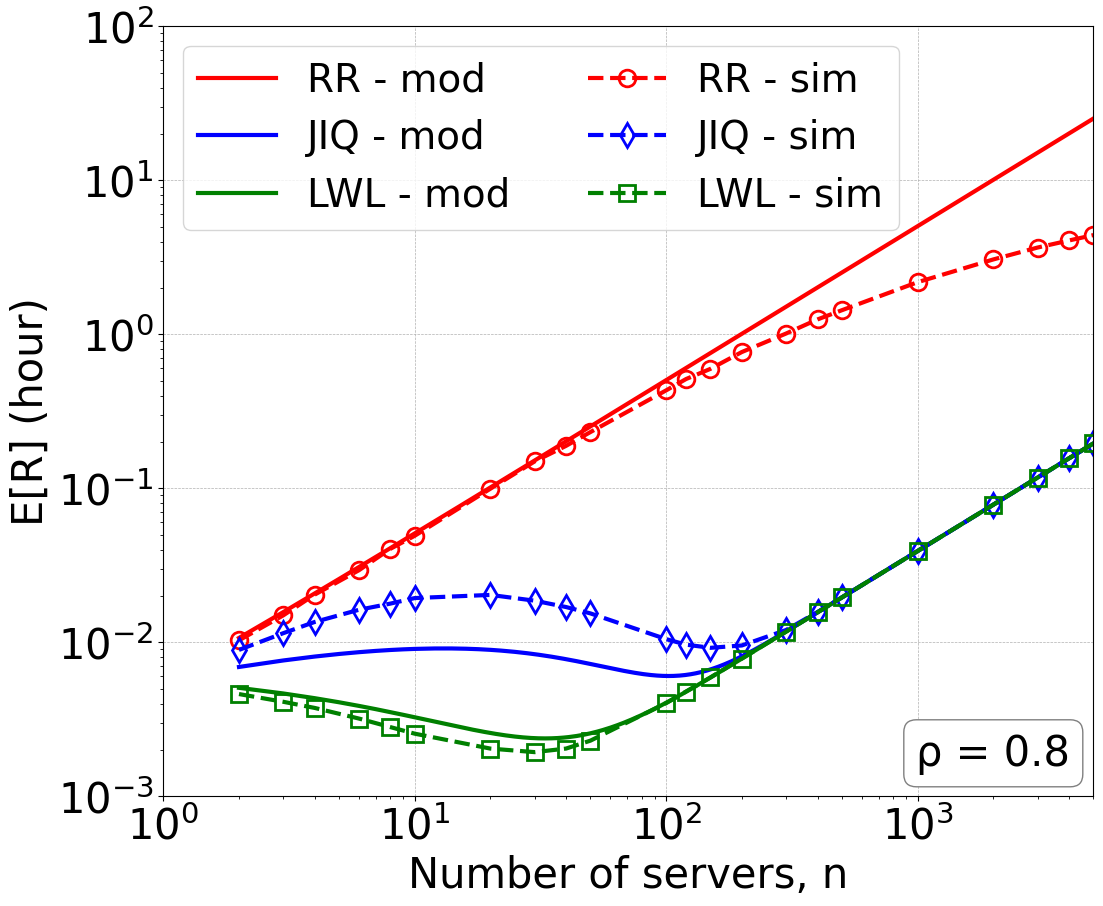

In [9]:
plt.figure(figsize=(12, 10))
plt.plot(Nv, y1v, 'r-', linewidth=3.0, label="RR - mod")
plt.plot(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - mod")
plt.plot(Nv, y3v, 'g-', linewidth=3.0, label="LWL - mod")

plt.plot(Nses, RR_FCFS_ERjob, 'r--o', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='RR - sim')  # Red dashed line with circles
plt.plot(Nses, JIQ_FCFS_ERjob, 'b--d', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='JIQ - sim')  # Blue dashed line with triangles
plt.plot(Nses, LWL_FCFS_ERjob, 'g--s', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='LWL - sim')  # Green dashed line with squares

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of servers, n', fontsize=30)
plt.ylabel('E[R] (hour)', fontsize=30)
plt.legend(loc="upper left", fontsize=28, ncol=2)


plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(LWL_FCFS_ERjob))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(
    0.81 * max(Nv), 0.23 * min(y2v),  # Adjust x and y coordinates
    f"ρ = {rho0}",
    fontsize=30,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)

plt.grid(True, which="major", linestyle='--', linewidth=0.5)

#plt.savefig('Outputs/ModSim_Matching_A.eps', format='eps',bbox_inches='tight')
plt.show()
